## Observations and Insights 

Based on the results of Pymaceuticals' recent animal study of potential treatments for squamous cell carcinoma, some observable trends in treatment effectiveness include the following: 

- 

## Initial Set-Up 

In [89]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
from scipy.stats import sem
from scipy.stats import linregress

# Study data files
mousecsv = '../Resources/Mouse_metadata.csv'
studycsv = '../Resources/Study_results.csv'

# Read the mouse data and the study results
mouse_data = pd.read_csv(mousecsv)
study_data = pd.read_csv(studycsv)

# Combine the data into a single dataset
combined_data = pd.merge(mouse_data, study_data, how='left', on=['Mouse ID'])

# Display the data table for preview
combined_data.head()

Mouse ID Drug Regimen   Sex  Age_months  Weight (g)  Timepoint  \
0     k403     Ramicane  Male          21          16          0   
1     k403     Ramicane  Male          21          16          5   
2     k403     Ramicane  Male          21          16         10   
3     k403     Ramicane  Male          21          16         15   
4     k403     Ramicane  Male          21          16         20   

   Tumor Volume (mm3)  Metastatic Sites  
0           45.000000                 0  
1           38.825898                 0  
2           35.014271                 1  
3           34.223992                 1  
4           32.997729                 1

#### -- Checking the number of mice 

In [90]:
# Find the total number of mice in the study by doing a count of the Mouse IDs in mouse_data
print(mouse_data['Mouse ID'].count())

# Group the study_data by Timepoint, and count the number of mice measured at each timepoint
check = study_data.groupby(['Timepoint'])
check.count()

# Compare the total number of mice in the study to the number of mice included at each timepoint
#---Total Mice (249) < Mouse ID count for Timepoint 0 (250) --> check shows that one mouse was measured twice at Timepoint 0 

249


Mouse ID  Tumor Volume (mm3)  Metastatic Sites
Timepoint                                                
0               250                 250               250
5               238                 238               238
10              223                 223               223
15              207                 207               207
20              195                 195               195
25              183                 183               183
30              171                 171               171
35              154                 154               154
40              142                 142               142
45              130                 130               130

#### -- Getting the duplicate mice by ID number that shows up for Mouse ID and Timepoint. 

In [91]:
# Check combined_data for mice that were measured more than once per Timepoint and separate them out into a variable 
#---use .duplicated() and have it look at both the Mouse ID *AND* Timepoint columns 
dupMouse_check = combined_data.duplicated(subset=["Mouse ID", "Timepoint"])

# For the dupMouse_check subset of combined_data, extract the unique values in the 'Mouse ID' column into a list
dupMouse_ID = combined_data[dupMouse_check]['Mouse ID'].unique()

# Print out the list to see the duplicated mice' IDs
print(dupMouse_ID)


['g989']


#### -- Get all the data for the duplicate mouse IDs.  

In [92]:
# Look through combined_data and pull out all the rows for the duplicated mice
#---use .isin() to narrow the search within the 'Mouse ID' column for IDs that match those contained in the dupMouse_ID list
dupMouse_data = combined_data.loc[combined_data['Mouse ID'].isin(dupMouse_ID)]

# Display the data for the duplicated mice (in this case, there is only one)
dupMouse_data

Mouse ID Drug Regimen     Sex  Age_months  Weight (g)  Timepoint  \
908     g989     Propriva  Female          21          26          0   
909     g989     Propriva  Female          21          26          0   
910     g989     Propriva  Female          21          26          5   
911     g989     Propriva  Female          21          26          5   
912     g989     Propriva  Female          21          26         10   
913     g989     Propriva  Female          21          26         10   
914     g989     Propriva  Female          21          26         15   
915     g989     Propriva  Female          21          26         15   
916     g989     Propriva  Female          21          26         20   
917     g989     Propriva  Female          21          26         20   
918     g989     Propriva  Female          21          26         25   
919     g989     Propriva  Female          21          26         30   
920     g989     Propriva  Female          21          26         35   

     Tumor Volume (mm3)  Metastatic Sites  
908           45.000000                 0  
909           45.000000                 0  
910           48.786801                 0  
911           47.570392                 0  
912           51.745156                 0  
913           49.880528                 0  
914           51.325852                 1  
915           53.442020                 0  
916           55.326122                 1  
917           54.657650                 1  
918           56.045564                 1  
919           59.082294                 1  
920           62.570880                 2

#### -- Create a clean DataFrame by dropping the duplicate mouse by its ID.

In [93]:
# Create a cleaned version of the combined dataset by dropping the dupMouse_data subset from combined_data
combined_clean = combined_data.drop(dupMouse_data.index)

# Check that the drop was successful by looking through combined_clean and pulling out all the rows for the duplicated mice
#---if successful, printing the results of the .loc[] should give an empty dataframe
drop_check = combined_clean.loc[combined_clean['Mouse ID'].isin(dupMouse_ID)]
print(drop_check)

# With the check passed, display the cleaned dataset for preview
combined_clean.head()

Empty DataFrame
Columns: [Mouse ID, Drug Regimen, Sex, Age_months, Weight (g), Timepoint, Tumor Volume (mm3), Metastatic Sites]
Index: []


Mouse ID Drug Regimen   Sex  Age_months  Weight (g)  Timepoint  \
0     k403     Ramicane  Male          21          16          0   
1     k403     Ramicane  Male          21          16          5   
2     k403     Ramicane  Male          21          16         10   
3     k403     Ramicane  Male          21          16         15   
4     k403     Ramicane  Male          21          16         20   

   Tumor Volume (mm3)  Metastatic Sites  
0           45.000000                 0  
1           38.825898                 0  
2           35.014271                 1  
3           34.223992                 1  
4           32.997729                 1

#### -- Checking the number of mice in the clean DataFrame.

In [94]:
# Double check that the number of unique Mouse IDs included in combined_clean dropped from the original total of 249
#---in this case, since there was only one duplicated mouse, the result should equal 248
print(len(combined_clean['Mouse ID'].unique()))


248


## Summary Statistics

#### -- Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen

In [95]:
# Use groupby and summary statistical methods to calculate the following properties of *each* drug regimen... 
combined_byDrugReg = combined_clean.groupby(['Drug Regimen'])

# Mean of the tumor volume 
drugReg_means = combined_byDrugReg['Tumor Volume (mm3)'].mean()

# Median of the tumor volume 
drugReg_medians = combined_byDrugReg['Tumor Volume (mm3)'].median()

# Variance of the tumor volume 
drugReg_vars = combined_byDrugReg['Tumor Volume (mm3)'].var()

# Standard deviation of the tumor volume
drugReg_stdevs = combined_byDrugReg['Tumor Volume (mm3)'].std()

# SEM of the tumor volume
drugReg_sems = combined_byDrugReg['Tumor Volume (mm3)'].sem()

# Assemble the resulting series into a single summary dataframe using pd.comcat() 
tumorVolSum_df = pd.concat([drugReg_means, drugReg_medians, drugReg_vars, drugReg_stdevs, drugReg_sems],
                           axis=1, keys= ['Mean', 'Median', 'Variance', 'Std. Dev.', 'SEM'])

# Display the summary statustics table for tumor volume by regimen
tumorVolSum_df


Mean     Median   Variance  Std. Dev.       SEM
Drug Regimen                                                      
Capomulin     40.675741  41.557809  24.947764   4.994774  0.329346
Ceftamin      52.591172  51.776157  39.290177   6.268188  0.469821
Infubinol     52.884795  51.820584  43.128684   6.567243  0.492236
Ketapril      55.235638  53.698743  68.553577   8.279709  0.603860
Naftisol      54.331565  52.509285  66.173479   8.134708  0.596466
Placebo       54.033581  52.288934  61.168083   7.821003  0.581331
Propriva      52.320930  50.446266  43.852013   6.622085  0.544332
Ramicane      40.216745  40.673236  23.486704   4.846308  0.320955
Stelasyn      54.233149  52.431737  59.450562   7.710419  0.573111
Zoniferol     53.236507  51.818479  48.533355   6.966589  0.516398

#### -- Using the aggregation method, produce the same summary statistics in a single line

In [96]:
# Use the .agg() function to calculate the mean, median, variance, std. dev, and SEM for Tumor Volume for each regimen
tumorVolSum_dfOneLine = combined_byDrugReg.agg(['mean', 'median', 'var', 'std', 'sem'])['Tumor Volume (mm3)']

# Display the summary statustics table for tumor volume by regimen
tumorVolSum_dfOneLine

mean     median        var       std       sem
Drug Regimen                                                     
Capomulin     40.675741  41.557809  24.947764  4.994774  0.329346
Ceftamin      52.591172  51.776157  39.290177  6.268188  0.469821
Infubinol     52.884795  51.820584  43.128684  6.567243  0.492236
Ketapril      55.235638  53.698743  68.553577  8.279709  0.603860
Naftisol      54.331565  52.509285  66.173479  8.134708  0.596466
Placebo       54.033581  52.288934  61.168083  7.821003  0.581331
Propriva      52.320930  50.446266  43.852013  6.622085  0.544332
Ramicane      40.216745  40.673236  23.486704  4.846308  0.320955
Stelasyn      54.233149  52.431737  59.450562  7.710419  0.573111
Zoniferol     53.236507  51.818479  48.533355  6.966589  0.516398

## Bar and Pie Charts

#### -- Generate a bar plot showing the total number of timepoints for all mice tested for each drug regimen using Pandas.

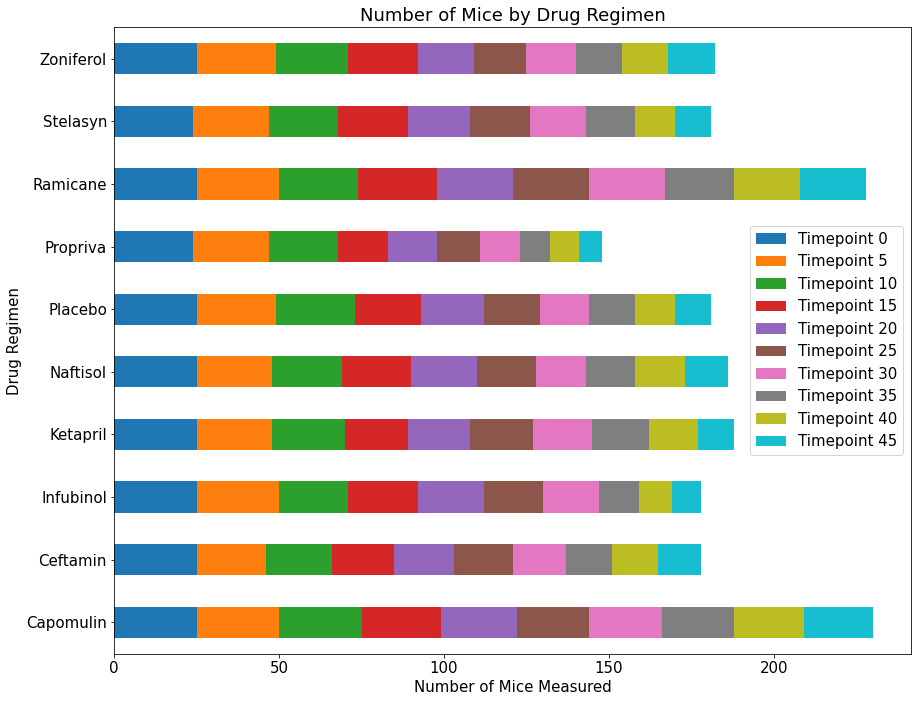

In [97]:
# Using the "Timepoint" column of combined_clean, grouped by "Drug Regimen",
# calculate the number of mice measured (under "Mouse ID") at each timepoint 
#---hold the counts counts for each timepoint in separate variables
drugReg_time0 = combined_clean[combined_clean['Timepoint'] == 0].groupby(['Drug Regimen'])['Mouse ID'].count()
drugReg_time5 = combined_clean[combined_clean['Timepoint'] == 5].groupby(['Drug Regimen'])['Mouse ID'].count()
drugReg_time10 = combined_clean[combined_clean['Timepoint'] == 10].groupby(['Drug Regimen'])['Mouse ID'].count()
drugReg_time15 = combined_clean[combined_clean['Timepoint'] == 15].groupby(['Drug Regimen'])['Mouse ID'].count()
drugReg_time20 = combined_clean[combined_clean['Timepoint'] == 20].groupby(['Drug Regimen'])['Mouse ID'].count()
drugReg_time25 = combined_clean[combined_clean['Timepoint'] == 25].groupby(['Drug Regimen'])['Mouse ID'].count()
drugReg_time30 = combined_clean[combined_clean['Timepoint'] == 30].groupby(['Drug Regimen'])['Mouse ID'].count()
drugReg_time35 = combined_clean[combined_clean['Timepoint'] == 35].groupby(['Drug Regimen'])['Mouse ID'].count()
drugReg_time40 = combined_clean[combined_clean['Timepoint'] == 40].groupby(['Drug Regimen'])['Mouse ID'].count()
drugReg_time45 = combined_clean[combined_clean['Timepoint'] == 45].groupby(['Drug Regimen'])['Mouse ID'].count()

# Collect the counts from each timepoint into a dataframe
#---will allow the bar chart of total mice counts for each drug regimen to be stacked properly based on counts per timepoint
drugReg_times_miceCounts = pd.DataFrame({'Timepoint 0': drugReg_time0,
                                        'Timepoint 5': drugReg_time5,
                                        'Timepoint 10': drugReg_time10,
                                        'Timepoint 15': drugReg_time15,
                                        'Timepoint 20': drugReg_time20,
                                        'Timepoint 25': drugReg_time25,
                                        'Timepoint 30': drugReg_time30,
                                        'Timepoint 35': drugReg_time35,
                                        'Timepoint 40': drugReg_time40,
                                        'Timepoint 45': drugReg_time45})

# Create the stacked bar chart, adding a title and appropriate axis labels
#---update the plot parameters to have the font size set to 15 to allow lables and title to show clearer
plt.rcParams.update({'font.size': 15})
drugReg_times_miceCounts.plot(kind='barh',stacked=True,figsize=(13,10),title='Number of Mice by Drug Regimen')

plt.xlabel('Number of Mice Measured')
plt.ylabel('Drug Regimen')
plt.tight_layout()

# Save the chart, and display it in the terminal
plt.savefig('Charts/NumberofMicebyDrugRegimen_bar_pandas.png')
plt.show()

#### -- Generate a bar plot showing the total number of timepoints for all mice tested for each drug regimen using pyplot.

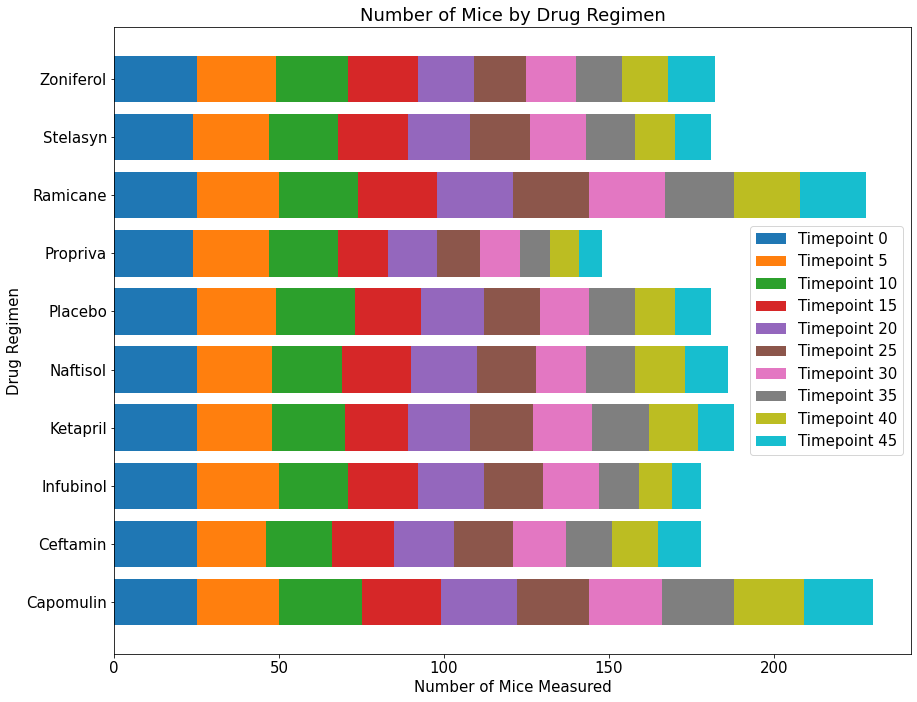

In [98]:
# Using the dataframe created before, set a list for the columns to look at 
times = ['Timepoint 0','Timepoint 5','Timepoint 10','Timepoint 15','Timepoint 20',
         'Timepoint 25','Timepoint 30','Timepoint 35','Timepoint 40','Timepoint 45']

# Set list for the matching colors for the bar segments
colors = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd',
          '#8c564b','#e377c2','#7f7f7f','#bcbd22','#17becf']

# Create bar plot with matching figure size
fig, ax = plt.subplots(1, figsize=(13,10))

# Create variable to specify the x coordinate for starting each bar segment
left = len(drugReg_times_miceCounts) * [0]

# Make a for loop that goes through the counts for each drug regimen at each timepoint in drugReg_times_miceCounts
#---use 'idx' and 'drug' so that it goes through each treatment listed in the dataframe index
for idx, drug in enumerate(times):
    #  create each bar segment for the mice counts for that drug 
    plt.barh(drugReg_times_miceCounts.index, drugReg_times_miceCounts[drug], left=left, color=colors[idx])
    # after the segment is made, reset 'left' to the count # for that segment so the next segment will start right after
    left = left + drugReg_times_miceCounts[drug]
    
# Set the chart title, axis labels, legend, and layout
plt.title('Number of Mice by Drug Regimen')
plt.xlabel('Number of Mice Measured')
plt.ylabel('Drug Regimen')
plt.legend(times)
plt.tight_layout()

# Save the chart, and display it in the terminal
plt.savefig('Charts/NumberofMicebyDrugRegimen_bar_pyplot.png')
plt.show()

#### -- Generate a pie plot showing the distribution of female versus male mice using Pandas.

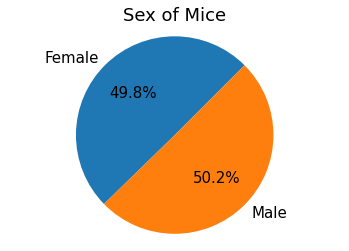

In [99]:
# Using mouse_data grouped by "Sex", count the number of mice under "Mouse ID" 
#---store the number of male and female mice in a dataframe 
sex_miceCounts = pd.DataFrame(mouse_data.groupby(['Sex'])['Mouse ID'].count())

# Create the pie chart of the 'Mouse ID' counts, adding a title and appropriate formatting 
sex_miceCounts.plot(kind='pie', y='Mouse ID', title='Sex of Mice', autopct='%1.1f%%',
                    startangle=45, legend=False, ylabel='')
plt.axis('equal')

# Save the chart, and display it in the terminal
plt.savefig('Charts/SexofMice_pie_pandas.png')
plt.show()

#### -- Generate a pie plot showing the distribution of female versus male mice using pyplot.

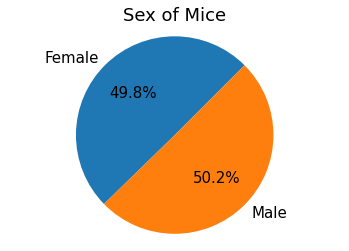

In [100]:
# Collect the index values from sex_miceCounts into a list to use as labels
sex = list(sex_miceCounts.index.values)

# Collect the 'Mouse ID' counts from sex_miceCounts into a list to use as the pie segments
sexCounts = list(sex_miceCounts['Mouse ID'])

# Create the pie chart of the 'Mouse ID' counts, adding a title and appropriate formatting 
plt.pie(sexCounts, labels=sex, autopct='%1.1f%%', startangle=45)
plt.title('Sex of Mice')
plt.axis('equal')

# Save the chart, and display it in the terminal
plt.savefig('Charts/SexofMice_pie_pyplot.png')
plt.show()

## Quartiles, Outliers and Boxplots

#### -- Calculate the final tumor volume of each mouse across four of the treatment regimens: Capomulin, Ramicane, Infubinol, and Ceftamin. Then, calculate the quartiles and IQR and determine if there are any potential outliers across all four treatment regimens.

In [101]:
# Start by getting the last (greatest) timepoint and final tumor volumes for each mouse in each drug regimen

# Create a list with the names of the drugs of interest
topdrugsList = ['Capomulin', 'Ramicane', 'Infubinol', 'Ceftamin']

# Look through combined_data and separate out the data for the drugs of interest
topdrugs_data = combined_data[combined_data['Drug Regimen'].isin(topdrugsList)]

# Create a dataframe for the extracted data with just the relevant columns
topdrugs_df = topdrugs_data[['Mouse ID', 'Drug Regimen', 'Timepoint', 'Tumor Volume (mm3)']]

# Group the dataframe by "Drug Regimen" and "Mouse ID",
# and pull out the max timepoint and final tumor volume for each mouse into a new column
topdrugs_lastTime = topdrugs_df.groupby(['Drug Regimen','Mouse ID']).agg(lastTime=('Timepoint', max),
                                                                         lastVol=('Tumor Volume (mm3)',lambda x: x.iloc[-1]))

# Reset the index and display the final subset dataframe
topdrugs_lastTime_df = topdrugs_lastTime.reset_index()
topdrugs_lastTime_df


Drug Regimen Mouse ID  lastTime    lastVol
0     Capomulin     b128        45  38.982878
1     Capomulin     b742        45  38.939633
2     Capomulin     f966        20  30.485985
3     Capomulin     g288        45  37.074024
4     Capomulin     g316        45  40.159220
..          ...      ...       ...        ...
95     Ramicane     s508        45  30.276232
96     Ramicane     u196        45  40.667713
97     Ramicane     w678         5  43.166373
98     Ramicane     y449        15  44.183451
99     Ramicane     z578        45  30.638696

[100 rows x 4 columns]

In [102]:
# Create an empty list to fill with the tumor volume data for each drug regimen (for plotting)
topdrugSubsets = []

# For each drug regimen, calculate the quartiles, IQR, and determine any potential outliers. 
#---use topdrugsList created earlier
for drug in topdrugsList:
    
    # Separate out the rows for each drug regimen into a subset dataframe
    drug_df = topdrugs_lastTime_df.loc[topdrugs_lastTime_df['Drug Regimen'] == drug]
    
    # Create a series for each drug that lists the all the mice's final tumor volumes (found under "lastVol")
    drug_lastVols = drug_df['lastVol']
    
    # Add the series to the topdrugSubsets list
    topdrugSubsets.append(drug_lastVols)
    
    # Calculate the lower and upper quartiles and the IQR for each drug
    quartiles = drug_lastVols.quantile([.25, .5, .75])
    lowerq = quartiles[.25]
    upperq = quartiles[.75]
    IQR = upperq - lowerq
    
    # Calculate the lower and upper bounds for each drug
    lower_bound = lowerq - (1.5*IQR)
    upper_bound = upperq + (1.5*IQR)
    
    # Based on the lower and upper bounds, locate any outliers and extract them into a list
    outliers = (drug_lastVols.loc[(drug_df['lastVol'] >= upper_bound) |
                                  (drug_df['lastVol'] <= lower_bound)]).tolist()
    
    # Print the quartile and outlier data for each drug into the terminal
    print('-------------------------------------------------------------')
    print(f"{drug} Quartiles and Outliers:")
    print(f" - The lower quartile of {drug} is: {lowerq}")
    print(f" - The upper quartile of {drug}  is: {upperq}")
    print(f" - The interquartile range of {drug}  is: {IQR}")
    print(f" - The the median of {drug}  is: {quartiles[0.5]} ")
    print(f" - Values below {lower_bound} could be outliers.")
    print(f" - Values above {upper_bound} could be outliers.")
    if outliers == []:
        print(f" - Outliers for {drug} include: NONE")
    else: 
        print(f" - Outliers for {drug} include: {outliers}")

print('-------------------------------------------------------------')

-------------------------------------------------------------
Capomulin Quartiles and Outliers:
 - The lower quartile of Capomulin is: 32.37735684
 - The upper quartile of Capomulin  is: 40.1592203
 - The interquartile range of Capomulin  is: 7.781863460000004
 - The the median of Capomulin  is: 38.1251644 
 - Values below 20.70456164999999 could be outliers.
 - Values above 51.83201549 could be outliers.
 - Outliers for Capomulin include: NONE
-------------------------------------------------------------
Ramicane Quartiles and Outliers:
 - The lower quartile of Ramicane is: 31.56046955
 - The upper quartile of Ramicane  is: 40.65900627
 - The interquartile range of Ramicane  is: 9.098536719999998
 - The the median of Ramicane  is: 36.56165229 
 - Values below 17.912664470000003 could be outliers.
 - Values above 54.30681135 could be outliers.
 - Outliers for Ramicane include: NONE
-------------------------------------------------------------
Infubinol Quartiles and Outliers:
 - The lo

#### -- Generate a box plot of the final tumor volume of each mouse across the four regimens of interest.

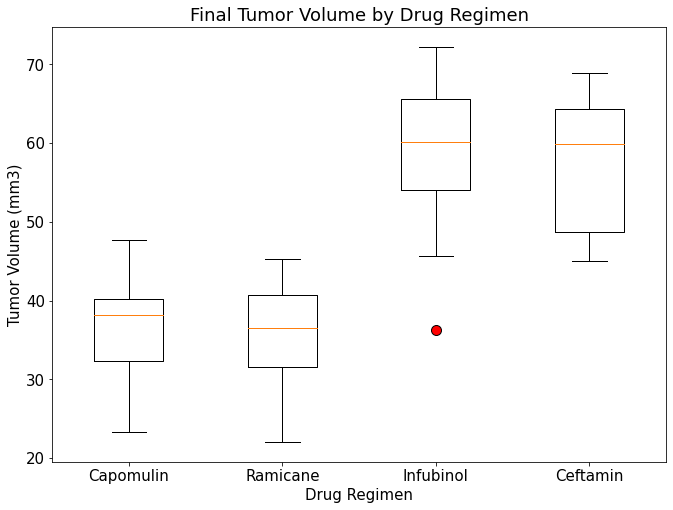

In [103]:
# Create the box and whisker plots for each of the drug regimens in topdrugSubsets
#---change the formatting to highlight the outliers more 
fig1, ax = plt.subplots(figsize=(11,8))
flierprops = dict(marker='o', markerfacecolor='r', markersize=10, markeredgecolor='black')
ax.boxplot(topdrugSubsets, flierprops=flierprops)

# Set the chart title, axis labels, and tick labels for the x-axis
ax.set_title('Final Tumor Volume by Drug Regimen')
ax.set_xlabel('Drug Regimen')
ax.set_ylabel('Tumor Volume (mm3)')
plt.xticks([1,2,3,4], topdrugsList)

# Save the chart, and display it in the terminal
plt.savefig('Charts/FinalTumorVolumebyDrugRegimen_BoxandWhisker.png')
plt.show()

## Line and Scatter Plots

#### -- Generate a line plot of tumor volume vs. time point for ONE mouse treated with Capomulin.

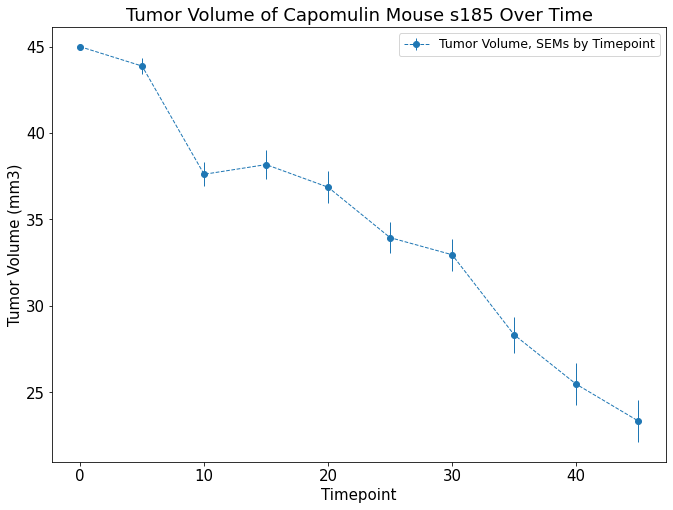

In [104]:
# Look through combined_data and separate out the data for the Capomulin mice into it's own dataframe
capomulin_df = combined_data[combined_data['Drug Regimen'] == 'Capomulin']

# Using the Capomulin dataframe, calculate the mean tumor volume and SEMs, at each timepoint
capomulin_tumorVol_byTime = capomulin_df.groupby(['Timepoint']).agg(tumorVol_Mean=('Tumor Volume (mm3)', np.mean),
                                                                    tumorVol_SEM=('Tumor Volume (mm3)', st.sem))

# Choose a mouse from the Capomulin dataset and separate out it's data from the Capomulin dataframe
capomulin_Mouse = capomulin_df[capomulin_df['Mouse ID'] == 's185']
                                                                    
# Extract the tumor volume measurements for the Capomulin mouse into a list for plotting the line points
capomulin_Mouse_tumorVol = capomulin_Mouse['Tumor Volume (mm3)'].tolist()

# Extract the timepoint values into a list to use as the x-axis
timepoints = capomulin_Mouse['Timepoint'].tolist()

# Create the line plot for the Capomulin Mouse's tumor volume over time
#---use plt.errorbar to show the line plot with the SEM error bars for each timepoint 
fig1, ax1 = plt.subplots(figsize=(11,8))
plt.errorbar(timepoints, capomulin_Mouse_tumorVol, yerr=capomulin_tumorVol_byTime['tumorVol_SEM'],
             fmt='--o', linewidth=1, label='Tumor Volume, SEMs by Timepoint')

# Set the chart title, axis labels, and legend
plt.title('Tumor Volume of Capomulin Mouse s185 Over Time')
plt.xlabel('Timepoint')
plt.ylabel('Tumor Volume (mm3)')
plt.legend(loc='best', fontsize='small', fancybox=True)

# Save the chart, and display it in the terminal
plt.savefig('Charts/TumorVolumeofCapomulinMouses185OverTime_line.png')
plt.show()

#### -- Generate a scatter plot of average tumor volume vs. mouse weight for the Capomulin regimen.

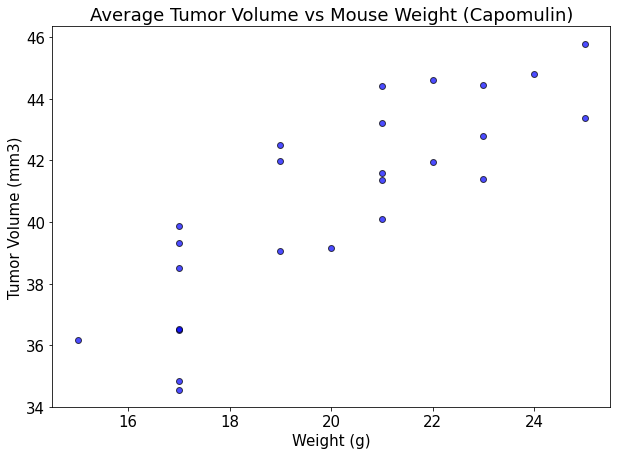

In [105]:
# Using the Capomulin dataframe, calculate the means for tumor volume and weight for each mouse
capomulin_tumorVol_byWeight = capomulin_df.groupby(['Mouse ID']).agg(tumorVol_Mean=('Tumor Volume (mm3)', np.mean),
                                                                     weight=('Weight (g)', np.mean))

# Create the scatter plot for avg tumor volume by weight, with appropriate formatting and labels
fig = plt.figure(figsize=(10,7))
plt.scatter(capomulin_tumorVol_byWeight['weight'], capomulin_tumorVol_byWeight['tumorVol_Mean'],
           marker='o', facecolors='blue', edgecolors='black', alpha=.7)
plt.title('Average Tumor Volume vs Mouse Weight (Capomulin)')
plt.xlabel('Weight (g)')
plt.ylabel('Tumor Volume (mm3)')

# Save the chart, and display it in the terminal
plt.savefig('Charts/AverageTumorVolumevsMouseWeight_scatter.png')
plt.show()

## Correlation and Regression

#### -- Calculate the correlation coefficient and linear regression model for mouse weight and average tumor volume for the Capomulin regimen. Plot the linear regression model on top of the previous scatter plot.

The correlation between average mouse weight and average tumor volume is 0.84
The coefficient of determination is 0.71
The equation of the regression line is y = 0.95x + 21.55


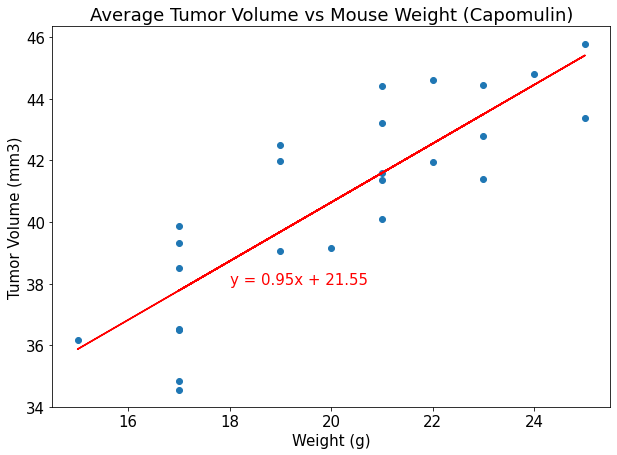

In [106]:
# Set the x (avg weight) and y (avg tumor volume) for the scatter plot
weightAvg = capomulin_tumorVol_byWeight['weight']
tumorvolAvg = capomulin_tumorVol_byWeight['tumorVol_Mean']

# Calculate the linear regression model for avg mouse weight and avg tumor volume
(slope, intercept, rvalue, pvalue, stderr) = linregress(weightAvg, tumorvolAvg)
regressLine = weightAvg * slope + intercept
regressEq = 'y = ' + str(round(slope,2)) + 'x + ' + str(round(intercept,2))

# Print the correlatio coefficient, coefficient of determination, and regression equation
print(f'The correlation between average mouse weight and average tumor volume is {round(rvalue,2)}')
print(f"The coefficient of determination is {round(rvalue**2,2)}")
print(f"The equation of the regression line is {regressEq}")

# Create the scatter plot with linear regression model for avg tumor volume by weight
fig1 = plt.figure(figsize=(10,7))
plt.scatter(weightAvg, tumorvolAvg)
plt.plot(weightAvg, regressLine, 'r-')
plt.annotate(regressEq, (18,38), fontsize=15, color='red')

# Set chart title and axis labels
plt.title('Average Tumor Volume vs Mouse Weight (Capomulin)')
plt.xlabel('Weight (g)')
plt.ylabel('Tumor Volume (mm3)')

# Save the chart, and display it in the terminal
plt.savefig('Charts/AverageTumorVolumevsMouseWeight_regression.png')
plt.show()